In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

!pip install visualkeras #https://github.com/paulgavrikov/visualkeras
import visualkeras

try: #Part of original notebook to set TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

     |████████████████████████████████| 992 kB 5.7 MB/s 
Number of replicas: 1
2.7.0


In [ ]:
import pathlib
dataset_url = "/content/drive/MyDrive/img_tirads"
data_dir = pathlib.Path(dataset_url)

In [ ]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1353


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync #GPU:1 num_replicas
IMAGE_SIZE = [100, 100]
EPOCHS = 100 #early stops in model.fit-->need to save best weights

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
# --seed: set seed value for shuffling the items. defaults to 1337.
splitfolders.ratio(data_dir, output="./", seed=1337, ratio=(.8, 0.1,0.1))

Copying files: 1353 files [00:17, 77.94 files/s] 


In [ ]:
train_folder= './train/'
val_folder = './val/'
test_folder = './test/'

In [ ]:
filepath = [] #list of paths of images of train & validation
categories = [] #label

In [ ]:
# Load the images path and label of the training set
filenames = os.listdir(os.path.join(train_folder,'Tiroides1'))
for filename in filenames:
        filepath.append(os.path.join(train_folder,'Tiroides1',filename))
        categories.append("Tiroides1") #0: Tirads 1

filenames = os.listdir(os.path.join(train_folder,'Tiroides2'))
for filename in filenames:
        filepath.append(os.path.join(train_folder,'Tiroides2',filename))
        categories.append("Tiroides2") #1: Tirads 2
        
filenames = os.listdir(os.path.join(train_folder,'Tiroides3'))
for filename in filenames:
        filepath.append(os.path.join(train_folder,'Tiroides3',filename))
        categories.append("Tiroides3") #2: Tirads 3
        
filenames = os.listdir(os.path.join(train_folder,'Tiroides4'))
for filename in filenames:
        filepath.append(os.path.join(train_folder,'Tiroides4',filename))
        categories.append("Tiroides4") #3: Tirads 3
        
filenames = os.listdir(os.path.join(train_folder,'Tiroides5'))
for filename in filenames:
        filepath.append(os.path.join(train_folder,'Tiroides5',filename))
        categories.append("Tiroides5") #4: Tirads 5

In [ ]:
# Load the images path and label of the validation set

filenames = os.listdir(os.path.join(val_folder,'Tiroides1'))
for filename in filenames:
        filepath.append(os.path.join(val_folder,'Tiroides1',filename))
        categories.append("Tiroides1") #0: Tirads 1
        
filenames = os.listdir(os.path.join(val_folder,'Tiroides2'))
for filename in filenames:
        filepath.append(os.path.join(val_folder,'Tiroides2',filename))
        categories.append("Tiroides2") #1: Tirads 2
        
filenames = os.listdir(os.path.join(val_folder,'Tiroides3'))
for filename in filenames:
        filepath.append(os.path.join(val_folder,'Tiroides3',filename))
        categories.append("Tiroides3") #2: Tirads 3
        
filenames = os.listdir(os.path.join(val_folder,'Tiroides4'))
for filename in filenames:
        filepath.append(os.path.join(val_folder,'Tiroides4',filename))
        categories.append("Tiroides4") #3: Tirads 4
        
filenames = os.listdir(os.path.join(val_folder,'Tiroides5'))
for filename in filenames:
        filepath.append(os.path.join(val_folder,'Tiroides5',filename))
        categories.append("Tiroides5") #4: Tirads 5

Df Train-Vali:                                  filepath      label
0       ./train/Tiroides1/tiroides21.jpg  Tiroides1
1       ./train/Tiroides1/tiroides73.jpg  Tiroides1
2    ./train/Tiroides1/tiroides (36).jpg  Tiroides1
3  ./train/Tiroides1/tiroides821 (9).jpg  Tiroides1
4       ./train/Tiroides1/tiroides27.jpg  Tiroides1

Tiroides4    387
Tiroides2    302
Tiroides3    200
Tiroides5    172
Tiroides1    153
Name: label, dtype: int64


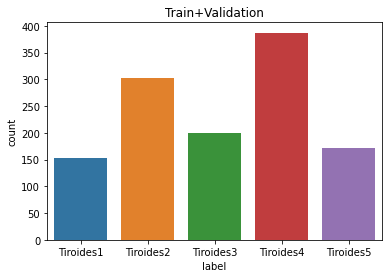

In [ ]:
df = pd.DataFrame({'filepath':filepath,'label':categories})
df.info
plot = sns.countplot(x ='label', data = df).set_title('Train+Validation')
print("Df Train-Vali: ",df.head())
print("")
print(df['label'].value_counts())

In [ ]:
train, vali = train_test_split(df, test_size=0.2,stratify=df['label'],random_state=6) #stratify to keep distribution

Train 80%: 
Tiroides4    309
Tiroides2    242
Tiroides3    160
Tiroides5    138
Tiroides1    122
Name: label, dtype: int64


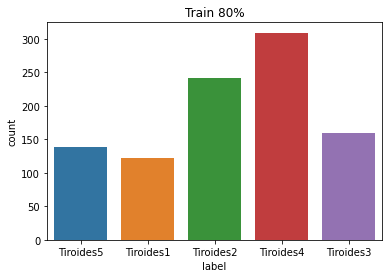

In [ ]:
plot_train = sns.countplot(x ='label', data = train).set_title('Train 80%')
print('Train 80%: ')
print(train['label'].value_counts())

Validation 20%: 
Tiroides4    78
Tiroides2    60
Tiroides3    40
Tiroides5    34
Tiroides1    31
Name: label, dtype: int64


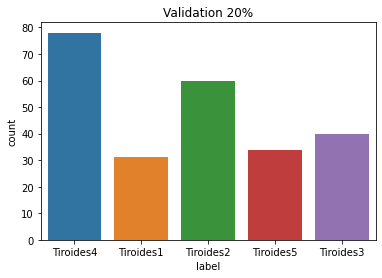

In [ ]:
plot_vali = sns.countplot(x ='label', data = vali).set_title('Validation 20%')
print('Validation 20%: ')
print(vali['label'].value_counts())

In [ ]:
# Data Augmentation

load = ImageDataGenerator() #To load images

In [ ]:
#Load images [0 255] and resize images

train_set = load.flow_from_dataframe(train,
                                        x_col = 'filepath',
                                        y_col = 'label',
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        class_mode = 'categorical')

vali_set = load.flow_from_dataframe(vali,
                                        x_col = 'filepath',
                                        y_col = 'label',
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        class_mode = 'categorical')

test_set = load.flow_from_directory(test_folder,
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        shuffle = False, #for confusionMatrix
                                        class_mode = 'categorical')

#Check classes in output
print("train: ",train_set.class_indices)
print("vali: ",vali_set.class_indices)
print("test: ",test_set.class_indices)
# it returns a DataFrameIterator yielding tuples of (x, y) where x is a numpy array containing 
# a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.

Found 971 validated image filenames belonging to 5 classes.
Found 243 validated image filenames belonging to 5 classes.
Found 139 images belonging to 5 classes.
train:  {'Tiroides1': 0, 'Tiroides2': 1, 'Tiroides3': 2, 'Tiroides4': 3, 'Tiroides5': 4}
vali:  {'Tiroides1': 0, 'Tiroides2': 1, 'Tiroides3': 2, 'Tiroides4': 3, 'Tiroides5': 4}
test:  {'Tiroides1': 0, 'Tiroides2': 1, 'Tiroides3': 2, 'Tiroides4': 3, 'Tiroides5': 4}


In [ ]:
VAL_IMG_COUNT = vali_set.samples
TEST_IMG_COUNT = test_set.samples

In [ ]:
print('Train: ',Counter(train_set.classes))
print('Validation: ',Counter(vali_set.classes))
print('Test: ',Counter(test_set.classes))

Train:  Counter({3: 309, 1: 242, 2: 160, 4: 138, 0: 122})
Validation:  Counter({3: 78, 1: 60, 2: 40, 4: 34, 0: 31})
Test:  Counter({3: 43, 1: 35, 2: 23, 4: 20, 0: 18})


In [ ]:
# Meaning of output of ImageDataGenerator

# print(len(train_set)) #number of batch in training set (from 0)
# print(train_set[0][0][1]) #list of images of first batch
# print((train_set[0][1])) #list of labels of first batch
print(train_set[0][0][1].shape) #shape of one image
# train_set[0][0][1] #float32

(100, 100, 3)


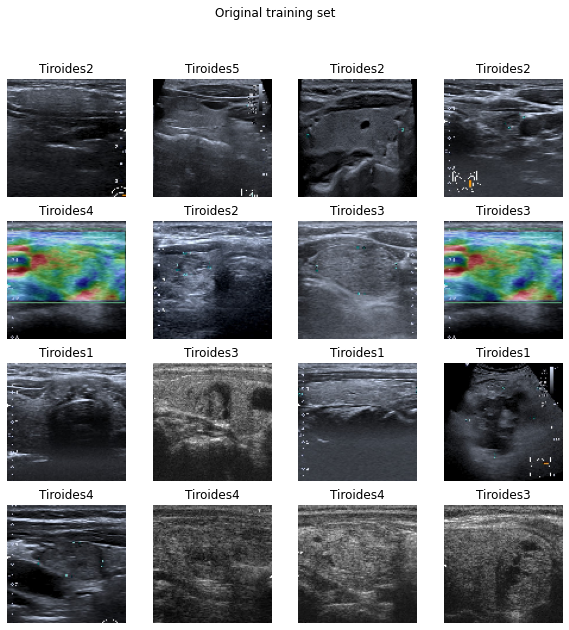

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle('Original training set')

for n in range(BATCH_SIZE):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(train_set[0][0][n].astype(np.uint8))  #uint8 to plot
        
    if train_set[0][1][n][0]== 1:
        plt.title("Tiroides1")
    elif train_set[0][1][n][1]== 1:
        plt.title("Tiroides2")
    elif train_set[0][1][n][2]==1:
        plt.title("Tiroides3")
    elif train_set[0][1][n][3]==1:
        plt.title("Tiroides4")
    else:
        plt.title("Tiroides5")
    plt.axis("off")

In [ ]:
augment_gen = ImageDataGenerator(zoom_range = 0.15,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.15,
                                   horizontal_flip=True,
                                   brightness_range=[0.2,1.2],
                                   fill_mode="nearest"
                                   ) #to perform augmentation on training set

In [ ]:
aug_train_set =  augment_gen.flow_from_dataframe(train,
                                        x_col = 'filepath',
                                        y_col = 'label',
                                        target_size = IMAGE_SIZE,
                                        batch_size = BATCH_SIZE,
                                        class_mode = 'categorical')
print("\n Aug_train: ",train_set.class_indices)

Found 971 validated image filenames belonging to 5 classes.

 Aug_train:  {'Tiroides1': 0, 'Tiroides2': 1, 'Tiroides3': 2, 'Tiroides4': 3, 'Tiroides5': 4}


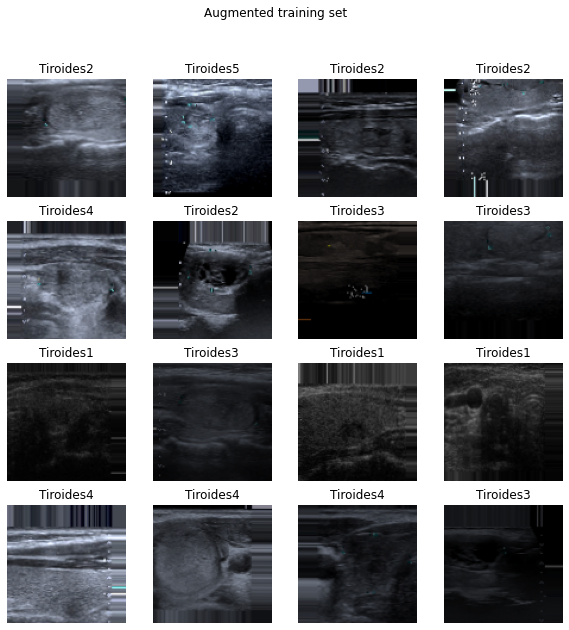

In [ ]:
plt.figure(figsize=(10,10))
plt.suptitle('Augmented training set')
for n in range(BATCH_SIZE):
    ax = plt.subplot(4,4,n+1)
    plt.imshow(aug_train_set[0][0][n].astype(np.uint8))
    
    if train_set[0][1][n][0]== 1:
        plt.title("Tiroides1")
    elif train_set[0][1][n][1]== 1:
        plt.title("Tiroides2")
    elif train_set[0][1][n][2]==1:
        plt.title("Tiroides3")
    elif train_set[0][1][n][3]==1:
        plt.title("Tiroides4")
    else:
        plt.title("Tiroides5")
    plt.axis("off")

Aug_train_set
Tiroides1 :  122
Tiroides2 :  242
Tiroides3 :  160
Tiroides4 :  309
Tiroides5 :  138


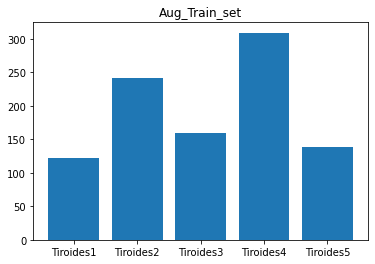

In [ ]:
counter = Counter(aug_train_set.classes)
#print(counter.items()) #0: Normal, 1: Pneumonia

counter['Tiroides1'] = counter.pop(0)
counter['Tiroides2'] = counter.pop(1)#change name for visualization dictionary
counter['Tiroides3'] = counter.pop(2)
counter['Tiroides4'] = counter.pop(3)
counter['Tiroides5'] = counter.pop(4)

print('Aug_train_set')
for i in counter:
    print(i,': ',counter[i])

plt.bar(counter.keys(),counter.values())
plt.title('Aug_Train_set')
plt.show()

In [ ]:
COUNT_TIRADS1=counter['Tiroides1']
COUNT_TIRADS2=counter['Tiroides2']
COUNT_TIRADS3=counter['Tiroides3']
COUNT_TIRADS4=counter['Tiroides4']
COUNT_TIRADS5=counter['Tiroides5']
TRAIN_IMG_COUNT=aug_train_set.samples

weight_for_0 = (1 / COUNT_TIRADS1)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_TIRADS2)*(TRAIN_IMG_COUNT)/2.0
weight_for_2 = (1 / COUNT_TIRADS3)*(TRAIN_IMG_COUNT)/2.0
weight_for_3 = (1 / COUNT_TIRADS4)*(TRAIN_IMG_COUNT)/2.0
weight_for_4 = (1 / COUNT_TIRADS5)*(TRAIN_IMG_COUNT)/2.0


class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))

Weight for class 0: 3.98
Weight for class 1: 2.01
Weight for class 2: 3.03
Weight for class 3: 1.57
Weight for class 4: 3.52


In [ ]:
# CNN

keras.backend.clear_session() #clear any model

In [ ]:
# Create a convolution block and a dense layer block

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Rescaling(scale=1./255), #Scaling images between [0 1]
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2), #Dropout layers to reduce overfitting
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(5, activation='sigmoid') #sigmoid activation function for the last layer, because it's a categorical classification
    ])

    return model

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=METRICS
    )
    
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 16)      2320      
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 16)      6416      
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                      

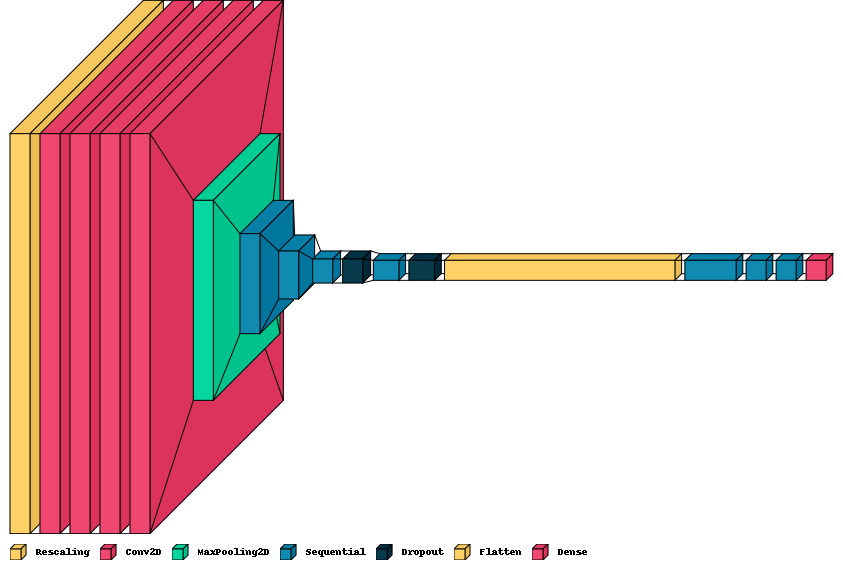

In [ ]:
visualkeras.layered_view(model, legend=True)

In [ ]:
print("steps_per_epoch : ",TRAIN_IMG_COUNT // BATCH_SIZE)
print("validation_steps : ",VAL_IMG_COUNT // BATCH_SIZE)

steps_per_epoch :  60
validation_steps :  15


In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("CNN_thyroid_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True,verbose=1)#check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=10, min_lr=0.001,verbose=1) #if val_loss not improved for patience_epochs-->reduce the learning rate

In [ ]:
history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb,early_stopping_cb,reduce_lr]
)

Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 6.1589 - accuracy: 0.2094 - precision: 0.1920 - recall: 0.4754
Epoch 00001: val_loss improved from inf to 1.70947, saving model to CNN_thyroid_model.h5
60/60 [==============================] - 23s 170ms/step - loss: 6.1589 - accuracy: 0.2094 - precision: 0.1920 - recall: 0.4754 - val_loss: 1.7095 - val_accuracy: 0.1375 - val_precision: 0.1375 - val_recall: 0.1375 - lr: 0.0010
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 5.3515 - accuracy: 0.1990 - precision: 0.2083 - recall: 0.5204
Epoch 00002: val_loss did not improve from 1.70947
60/60 [==============================] - 9s 151ms/step - loss: 5.3515 - accuracy: 0.1990 - precision: 0.2083 - recall: 0.5204 - val_loss: 1.7736 - val_accuracy: 0.1417 - val_precision: 0.1417 - val_recall: 0.1417 - lr: 0.0010
Epoch 3/100
60/60 [==============================] - ETA: 0s - loss: 5.2100 - accuracy: 0.2084 - precision: 0.2037 - recall: 0.5079
Epoch 00003

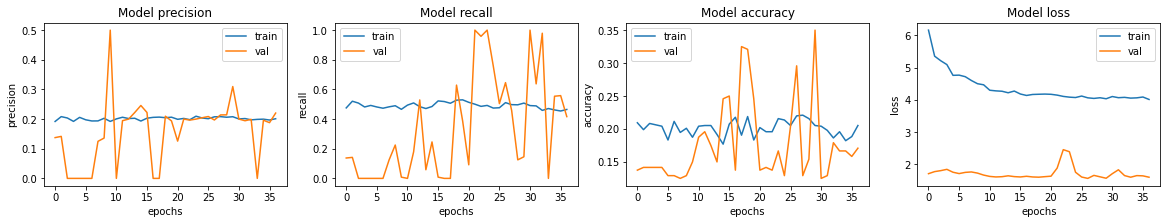

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
#Load model for interactive session
#keras.backend.clear_session()
#model = keras.models.load_model('../input/models/CNN_xray_model.h5')

In [ ]:
loss, acc, prec, rec = model.evaluate(test_set)

9/9 [==============================] - 1s 63ms/step - loss: 1.5742 - accuracy: 0.2806 - precision: 0.2080 - recall: 0.7122


In [ ]:
#Predicted labels
predictions = model.predict(test_set)
# predictions = predictions > 0.5
# predictions = predictions[0]

lista = []

for indice, elemento in enumerate(predictions):
    #predictions[indice] = np.argmax(elemento)
    lista.append(np.argmax(elemento))

#True labels
orig = test_set.labels
print(len(orig))
print(len(predictions))
# orig = np.argmax(predictions[0])
# print(orig)
# print(np.argmax(predictions[0]))
# print(predictions.shape)
# print(predictions[0])
# print(lista)

139
139


In [ ]:
cm = confusion_matrix(orig, lista)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(orig,  lista)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[ 0  0  0 15  3]
 [ 0  0  0 24 11]
 [ 2  0  0 21  0]
 [ 1  0  0 39  3]
 [ 0  0  0 20  0]]

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.00      0.00      0.00        35
           2       0.00      0.00      0.00        23
           3       0.33      0.91      0.48        43
           4       0.00      0.00      0.00        20

    accuracy                           0.28       139
   macro avg       0.07      0.18      0.10       139
weighted avg       0.10      0.28      0.15       139




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


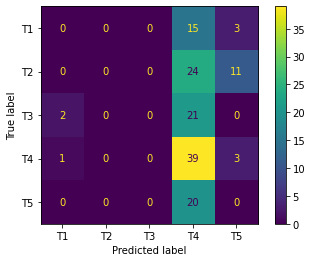

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['T1','T2','T3','T4','T5'])
disp.plot()

errori commessi:  100


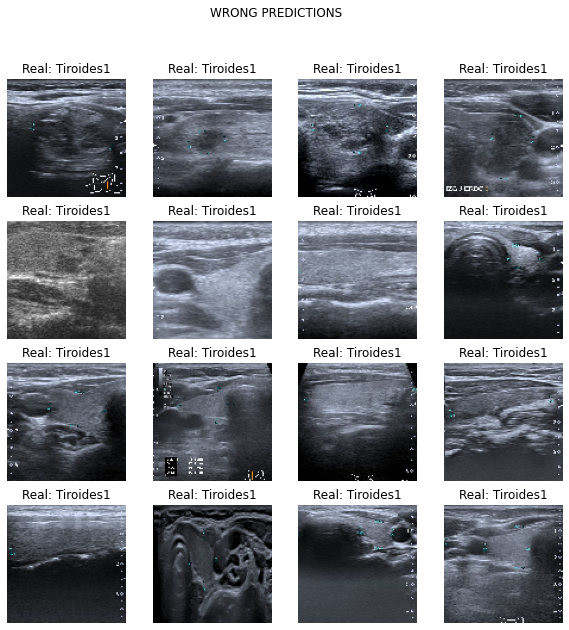

In [ ]:
err=[i for i, (x, y) in enumerate(zip(lista, orig)) if x != y] #check where orig and predictions don't match (wrong classification)
#print(err)
print('errori commessi: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): #plot max 16 wrong predictions
    bn=err[n]//BATCH_SIZE #number of batch of wrong prediction train_set[bn][0][image]
    ib=err[n]-BATCH_SIZE*bn #number of the image in the batch size train_set[bn][0][ib]
    #print('id_err:',err[n],' batch:',bn,' diff:',err[n]-BATCH_SIZE*bn)
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  #uint8 to plot
    
    if test_set[bn][1][ib][0]==1: #real value
        plt.title("Real: Tiroides1")
    elif test_set[bn][0][ib][1]==1:
        plt.title("Real: Tiroides2")
    elif test_set[bn][0][ib][2]==1:
        plt.title("Real: Tiroides3")
    elif test_set[bn][0][ib][3]==1:
        plt.title("Real: Tiroides4")
    else:
        plt.title("Real: Tiroides5")
    plt.axis("off")

In [ ]:
# Transfer Learning Xception + Fine Tuning
keras.backend.clear_session()

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-train ImageNet
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False)  # Do not include the ImageNet classifier at the top

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Freeze the base of the model
base_model.trainable = False #freeze the base model

In [ ]:
inputs = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

#Preprocess for Xception
x = tf.keras.applications.xception.preprocess_input(inputs)

# We make sure that the base_model is running in inference mode here passing `training=False`
x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

# A Dense classifier with a single unit (categorical classification)
outputs = keras.layers.Dense(5, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 100, 100, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=6,
                                                     restore_best_weights=True,verbose=1)#check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) #min_lr as input for fine tuning next

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)

Epoch 1/100
60/60 [==============================] - 14s 170ms/step - loss: 4.1084 - accuracy: 0.2932 - val_loss: 1.4813 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 2/100
60/60 [==============================] - 9s 148ms/step - loss: 3.7981 - accuracy: 0.3560 - val_loss: 1.4853 - val_accuracy: 0.4125 - lr: 0.0010
Epoch 3/100
60/60 [==============================] - 9s 147ms/step - loss: 3.7863 - accuracy: 0.3906 - val_loss: 1.5198 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 3.7314 - accuracy: 0.3885
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
60/60 [==============================] - 9s 147ms/step - loss: 3.7314 - accuracy: 0.3885 - val_loss: 1.5374 - val_accuracy: 0.3708 - lr: 0.0010
Epoch 5/100
60/60 [==============================] - 9s 147ms/step - loss: 3.6216 - accuracy: 0.3916 - val_loss: 1.5234 - val_accuracy: 0.3792 - lr: 2.0000e-04
Epoch 6/100
60/60 [==============================] 

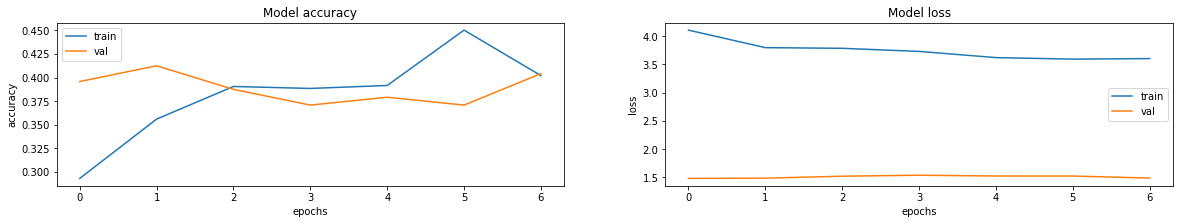

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Fine Tuning
# Unfreeze the base model

base_model.trainable = True
model.summary()
model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics='accuracy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 100, 100, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Xception_thyroid_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) #check val_loss

In [ ]:
# Fine Tuning
# Unfreeze the base model

base_model.trainable = True

model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-5), #Very low learning rate
              loss='categorical_crossentropy',
              metrics='accuracy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 100, 100, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("Xception_thyroid_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1) #check val_loss

In [ ]:
history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb,early_stopping_cb]
)

Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 3.8336 - accuracy: 0.3654
Epoch 00001: val_loss improved from inf to 1.42945, saving model to Xception_thyroid_model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


60/60 [==============================] - 25s 312ms/step - loss: 3.8336 - accuracy: 0.3654 - val_loss: 1.4295 - val_accuracy: 0.4417
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 3.6977 - accuracy: 0.4147
Epoch 00002: val_loss did not improve from 1.42945
60/60 [==============================] - 16s 258ms/step - loss: 3.6977 - accuracy: 0.4147 - val_loss: 1.4303 - val_accuracy: 0.3958
Epoch 3/100
60/60 [==============================] - ETA: 0s - loss: 3.6226 - accuracy: 0.4293
Epoch 00003: val_loss did not improve from 1.42945
60/60 [==============================] - 16s 257ms/step - loss: 3.6226 - accuracy: 0.4293 - val_loss: 1.4373 - val_accuracy: 0.3958
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 3.5745 - accuracy: 0.4220
Epoch 00004: val_loss improved from 1.42945 to 1.39256, saving model to Xception_thyroid_model.h5
60/60 [==============================] - 17s 280ms/step - loss: 3.5745 - accuracy: 0.4220 - val_loss: 1.3926 - val_accu

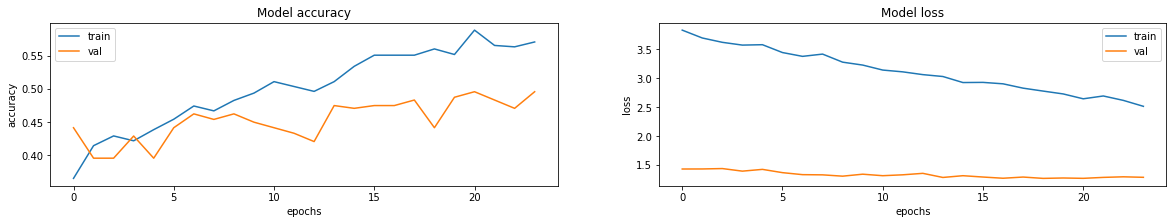

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
#Load model for interactive session
#keras.backend.clear_session()
#model = keras.models.load_model('../input/models/Xception_xray_model.h5')

In [ ]:
loss, acc = model.evaluate(test_set)

9/9 [==============================] - 1s 76ms/step - loss: 1.3706 - accuracy: 0.4460


In [ ]:
predictions = model.predict(test_set)

lista = []

for indice, elemento in enumerate(predictions):
    lista.append(np.argmax(elemento))

#True labels
orig = test_set.labels
print(len(orig))
print(len(predictions))

139
139


In [ ]:
cm = confusion_matrix(orig, lista)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(orig, lista)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[ 4  5  3  4  2]
 [ 2 22  6  4  1]
 [ 1  1 10  5  6]
 [ 4  2 11 20  6]
 [ 2  1  6  5  6]]

Classification report:
              precision    recall  f1-score   support

           0       0.31      0.22      0.26        18
           1       0.71      0.63      0.67        35
           2       0.28      0.43      0.34        23
           3       0.53      0.47      0.49        43
           4       0.29      0.30      0.29        20

    accuracy                           0.45       139
   macro avg       0.42      0.41      0.41       139
weighted avg       0.47      0.45      0.45       139




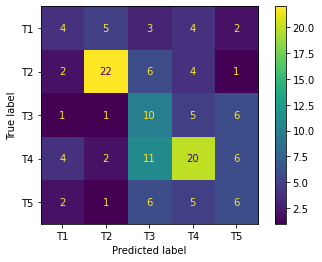

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['T1','T2','T3','T4','T5'])
disp.plot()

errori commessi:  77


ValueError: ignored

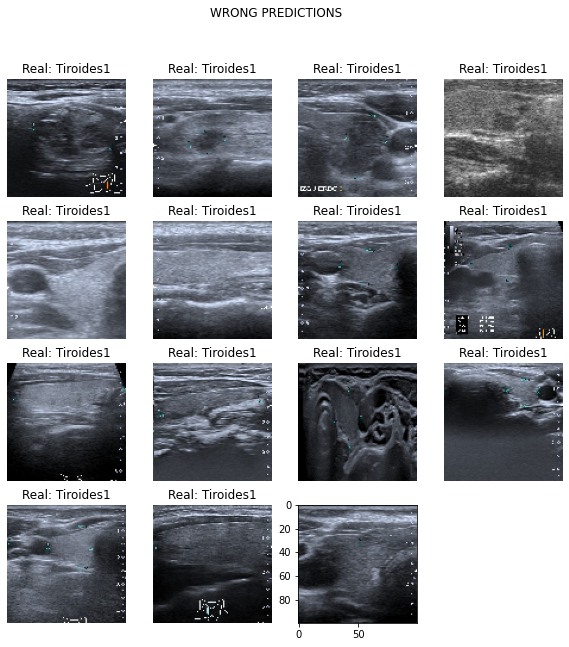

In [ ]:
err=[i for i, (x, y) in enumerate(zip(lista, orig)) if x != y] #check where orig and predictions don't match (wrong classification)
#print(err)
print('errori commessi: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): #plot max 16 wrong predictions
    bn=err[n]//BATCH_SIZE #number of batch of wrong prediction train_set[bn][0][image]
    ib=err[n]-BATCH_SIZE*bn #number of the image in the batch size train_set[bn][0][ib]
    #print('id_err:',err[n],' batch:',bn,' diff:',err[n]-BATCH_SIZE*bn)
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  #uint8 to plot
    
    if test_set[bn][1][ib][0]==1: #real value
        plt.title("Real: Tiroides1")
    elif test_set[bn][0][ib][1]==1:
        plt.title("Real: Tiroides2")
    elif test_set[bn][0][ib][2]==1:
        plt.title("Real: Tiroides3")
    elif test_set[bn][0][ib][3]==1:
        plt.title("Real: Tiroides4")
    else:
        plt.title("Real: Tiroides5")
    plt.axis("off")

In [ ]:
# Transfer Learning ResNet + Fine Tuning
keras.backend.clear_session()

In [ ]:
base_model = keras.applications.ResNet152V2(
    weights='imagenet',  # Load weights pre-trained on ImageNet
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
    include_top=False)  # Do not include the ImageNet classifier at the top

234561536/234545216 [==============================] - 2s 0us/step


In [ ]:
base_model.trainable = False #freeze the base model

In [ ]:
inputs = keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

#Preprocess for ResNet152V2
x = tf.keras.applications.resnet_v2.preprocess_input(inputs)

# We make sure that the base_model is running in inference mode here, passing `training=False`
x = base_model(x, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

# A Dense classifier with a single unit (categorical classification)
outputs = keras.layers.Dense(5, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 100, 100, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=6,
                                                     restore_best_weights=True,verbose=1)#check val_loss

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=1e-5 ,verbose=1) #min_lr as input for fine tuning next

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early_stopping_cb, reduce_lr]
)

Epoch 1/100
60/60 [==============================] - 28s 296ms/step - loss: 4.5903 - accuracy: 0.2869 - val_loss: 1.5529 - val_accuracy: 0.3292 - lr: 0.0010
Epoch 2/100
60/60 [==============================] - 12s 203ms/step - loss: 3.8873 - accuracy: 0.3277 - val_loss: 1.6024 - val_accuracy: 0.2625 - lr: 0.0010
Epoch 3/100
60/60 [==============================] - 12s 203ms/step - loss: 3.8091 - accuracy: 0.3738 - val_loss: 1.5987 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 3.6537 - accuracy: 0.3916
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
60/60 [==============================] - 12s 203ms/step - loss: 3.6537 - accuracy: 0.3916 - val_loss: 1.5598 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 5/100
60/60 [==============================] - 12s 204ms/step - loss: 3.5611 - accuracy: 0.4241 - val_loss: 1.5762 - val_accuracy: 0.3750 - lr: 2.0000e-04
Epoch 6/100
60/60 [============================

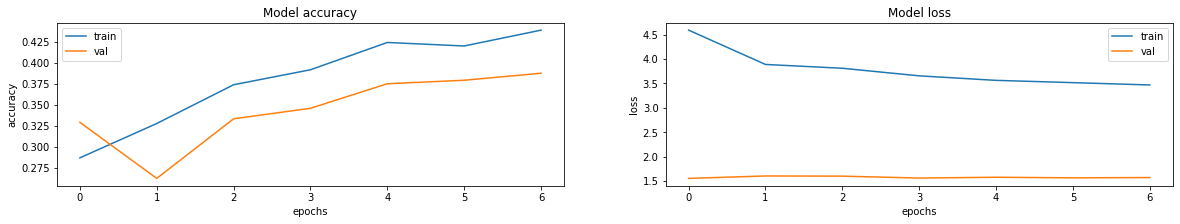

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
# Unfreeze the base model
base_model.trainable = True

model.summary()

model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss='categorical_crossentropy',
              metrics='accuracy')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 100, 100, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 100, 100, 3)      0         
 a)                                                              
                                                                 
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("ResNet152V2_xray_model.h5",
                                                    save_best_only=True,verbose=1)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True,verbose=1)#check val_loss

In [ ]:
history = model.fit(
    aug_train_set,
    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
    epochs=100,
    validation_data=vali_set,
    validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb,early_stopping_cb]
)

Epoch 1/100
60/60 [==============================] - ETA: 0s - loss: 3.8612 - accuracy: 0.3634
Epoch 00001: val_loss improved from inf to 1.48448, saving model to ResNet152V2_xray_model.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


60/60 [==============================] - 65s 759ms/step - loss: 3.8612 - accuracy: 0.3634 - val_loss: 1.4845 - val_accuracy: 0.4042
Epoch 2/100
60/60 [==============================] - ETA: 0s - loss: 3.7080 - accuracy: 0.3843
Epoch 00002: val_loss improved from 1.48448 to 1.38589, saving model to ResNet152V2_xray_model.h5
60/60 [==============================] - 41s 686ms/step - loss: 3.7080 - accuracy: 0.3843 - val_loss: 1.3859 - val_accuracy: 0.4208
Epoch 3/100
60/60 [==============================] - ETA: 0s - loss: 3.5340 - accuracy: 0.4251
Epoch 00003: val_loss improved from 1.38589 to 1.35904, saving model to ResNet152V2_xray_model.h5
60/60 [==============================] - 41s 687ms/step - loss: 3.5340 - accuracy: 0.4251 - val_loss: 1.3590 - val_accuracy: 0.4625
Epoch 4/100
60/60 [==============================] - ETA: 0s - loss: 3.4211 - accuracy: 0.4293
Epoch 00004: val_loss improved from 1.35904 to 1.35501, saving model to ResNet152V2_xray_model.h5
60/60 [==================

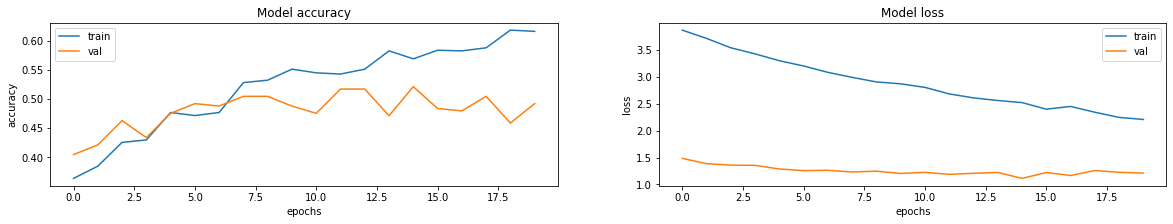

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
#Load model for interactive session
#keras.backend.clear_session()
#model = keras.models.load_model('../input/models/Xception_xray_model.h5')

In [ ]:
loss, acc = model.evaluate(test_set)

9/9 [==============================] - 1s 154ms/step - loss: 1.1946 - accuracy: 0.4532


In [ ]:
#Predicted labels
predictions = model.predict(test_set)
# predictions = predictions > 0.5
# predictions = predictions[0]

lista = []

for indice, elemento in enumerate(predictions):
    #predictions[indice] = np.argmax(elemento)
    lista.append(np.argmax(elemento))

#True labels
orig = test_set.labels
print(len(orig))
print(len(predictions))

139
139


In [ ]:
cm = confusion_matrix(orig, lista)
print('Confusion matrix:')
print(cm)
print('')

cr = classification_report(orig, lista)
print('Classification report:')
print(cr)
print('')

Confusion matrix:
[[ 6  3  1  7  1]
 [ 2 22  8  3  0]
 [ 1  1 10  7  4]
 [ 2  2 14 20  5]
 [ 2  1  5  7  5]]

Classification report:
              precision    recall  f1-score   support

           0       0.46      0.33      0.39        18
           1       0.76      0.63      0.69        35
           2       0.26      0.43      0.33        23
           3       0.45      0.47      0.46        43
           4       0.33      0.25      0.29        20

    accuracy                           0.45       139
   macro avg       0.45      0.42      0.43       139
weighted avg       0.48      0.45      0.46       139




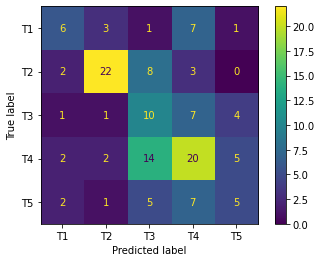

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['T1','T2','T3','T4','T5'])
disp.plot()

errori commessi:  76


ValueError: ignored

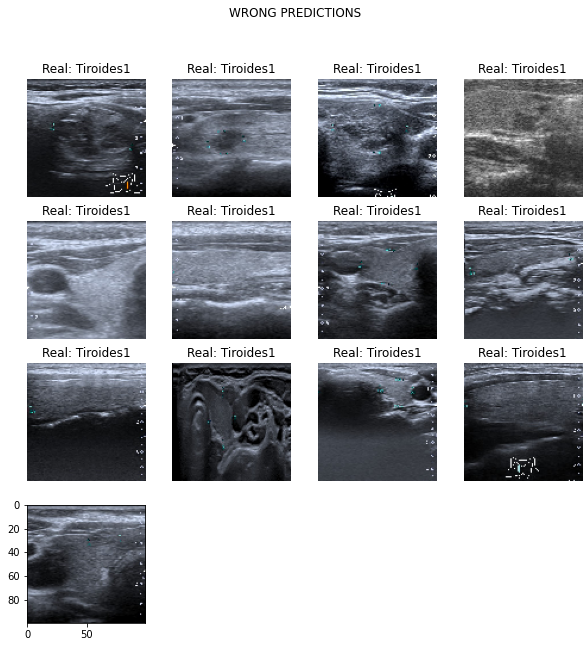

In [ ]:
err=[i for i, (x, y) in enumerate(zip(lista, orig)) if x != y] #check where orig and predictions don't match (wrong classification)
#print(err)
print('errori commessi: ',len(err))

plt.figure(figsize=(10,10))
plt.suptitle("WRONG PREDICTIONS")
for n in range(16): #plot max 16 wrong predictions
    bn=err[n]//BATCH_SIZE #number of batch of wrong prediction train_set[bn][0][image]
    ib=err[n]-BATCH_SIZE*bn #number of the image in the batch size train_set[bn][0][ib]
    #print('id_err:',err[n],' batch:',bn,' diff:',err[n]-BATCH_SIZE*bn)
    ax = plt.subplot(4,4,n+1)
    plt.imshow(test_set[bn][0][ib].astype(np.uint8))  #uint8 to plot
    
    if test_set[bn][1][ib][0]==1: #real value
        plt.title("Real: Tiroides1")
    elif test_set[bn][0][ib][1]==1:
        plt.title("Real: Tiroides2")
    elif test_set[bn][0][ib][2]==1:
        plt.title("Real: Tiroides3")
    elif test_set[bn][0][ib][3]==1:
        plt.title("Real: Tiroides4")
    else:
        plt.title("Real: Tiroides5")
    plt.axis("off")